<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Reconstruct%20DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstruction of a density matrix

### Import dependencies for Google Colab

In [1]:
from IPython.display import clear_output
! git clone https://github.com/nahumsa/DM-Reconstruction
clear_output()

In [3]:
% cd DM-Reconstruction/
clear_output()

##Import Dependencies

In [4]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm

## Creating dataset

In [7]:
X_train = np.loadtxt('Data/Measurements/X_train.txt')
X_test = np.loadtxt('Data/Measurements/X_test.txt')

# Models

## Using Trace distance as a loss function

In [22]:
from Models.TVAE import TraceVAE

ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

vae = TraceVAE(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM,
               dropout_rate=dropout_rate)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
val_dataset = tf.data.Dataset.from_tensor_slices(X_test)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batchsize)

In [23]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-1
epochs = 25

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs, val_loss_epochs, fidelity_epochs, val_fidelity_epochs = vae.training(dataset, 
                                                                                  epochs, 
                                                                                  r_loss, 
                                                                                  beta,
                                                                                  test=val_dataset, 
                                                                                  )#Plotter=plotter)

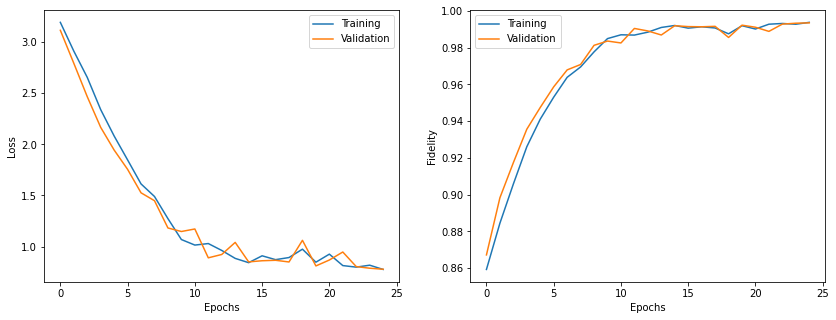

In [25]:
epochs = range(len(loss_epochs))

fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs,loss_epochs, label='Training')
ax1.plot(epochs,val_loss_epochs, label='Validation')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,fidelity_epochs, label='Training')
ax2.plot(epochs,val_fidelity_epochs, label='Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Fidelity')
ax2.legend()
plt.show()

In [28]:
# Saving results
save = False
if save:
  np.savetxt('Results/TVAE/TVAE_Fidelity.txt', fidelity_epochs)
  np.savetxt('Results/TVAE/TVAE_Loss.txt', loss_epochs)
  np.savetxt('Results/TVAE/val_TVAE_Fidelity.txt', val_fidelity_epochs)
  np.savetxt('Results/TVAE/val_TVAE_Loss.txt', val_loss_epochs)

# Denoising measurements with error

In [ ]:
from Utils.Dataset import create_x
n_measurements = len(measurements_train[0])
noise_factor = 0.1

#Transforming in an np.array
X_train = np.array(create_x(measurements_train)) + noise_factor*np.random.randn(samples_train,n_measurements)
Y_train = np.array(create_x(measurements_train))
labels_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test)) + noise_factor*np.random.randn(samples_test,n_measurements)
Y_test = np.array(create_x(measurements_test))
labels_test = np.array(labels_test)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y: {Y_train.shape}")
print(f"Shape of the Training: \n X: {X_test.shape} \n Y: {Y_test.shape}")

In [ ]:
from Models.TVAE import TraceVAE
from Utils.QMetrics import trace_loss, fidelity_rho

class Denoise(TraceVAE):
  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,               
               dropout_rate,
               **kwargs):    

    super(Denoise, self).__init__(original_dim,
                                   intermediate_dim,
                                   latent_dim,
                                   dropout_rate)
      
  def training_step(self, x, y, r_loss, beta):
    """Training step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data with noise
    y: Data without noise
    VAE(tf.keras.Model): Variational Autoencoder model. 
    optimizer(tf.keras.optimizer): Optimizer used.  
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.

    Return:
    Loss(float): Loss value of the training step.

    """
    with tf.GradientTape() as tape:
      reconstructed = self(x)  # Compute input reconstruction.
      # Compute loss.      
      loss = trace_loss(y, reconstructed)
      kl = sum(self.losses)
      loss = r_loss * loss + beta*kl  
    
    # Update the weights of the VAE.
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))    
    
    fid = fidelity_rho(y, rescontructed)

    return loss, np.mean(fid)

  def validating_step(self, x, y, r_loss, beta):
    """Validation step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data    
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.

    Return:
    Loss(float): Loss value of the training step.

    """

    reconstructed = self(x)  # Compute input reconstruction.
    # Compute loss.      
    loss = trace_loss(y, reconstructed)
    kl = sum(self.losses)
    loss = r_loss * loss + beta*kl
    fid = fidelity_rho(y, rescontructed)

    return loss, np.mean(fid)

  def training(self, dataset,
             epochs, r_loss, beta,              
             test=None, Plotter=None):
    """ Training of the Variational Autoencoder for a 
    tensorflow.dataset.

    Parameters
    -------------------------------------------
    dataset(tf.data.Dataset): Dataset of the data.
    VAE(tf.keras.Model): Variational Autoencoder model.
    epochs(int): Number of epochs.
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.  
    Plotter(object): Plotter object to show how the training is
                    going (Default=None).

    """

    losses = []
    val_losses = []   
    fidelities = []
    val_fidelities = [] 
    epochs = range(epochs)

    for i in tqdm(epochs, desc='Epochs'):
      losses_epochs = []
      fidelity_epochs =[]
      for step, (x, y) in enumerate(dataset):

        loss, fidelity = self.training_step(x, y, r_loss, beta)
  
        # Logging.
        losses_epochs.append(float(loss))
        fidelity_epochs.append(float(fidelity))
      
      losses.append(np.mean(losses_epochs))
      fidelities.append(np.mean(fidelity_epochs))

      if test:
        val_losses_epochs = []
        val_fidelity_epochs = []

        for step, (x, y) in enumerate(test):
          val_loss, val_fidelity = self.validating_step(x, y, r_loss, beta)
    
          # Logging.
          val_losses_epochs.append(float(val_loss))
          val_fidelity_epochs.append(float(val_fidelity))
        
        val_losses.append(np.mean(val_losses_epochs))  
        val_fidelities.append(np.mean(val_fidelity_epochs))
      
      if Plotter != None:
        if test:
          Plotter.plot([losses,val_losses])
        else:
          Plotter.plot(losses)
        

    return losses, val_losses, fidelities, val_fidelities

In [ ]:
ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

denoise = Denoise(original_dim=input_dim,
                   intermediate_dim=hidden_dims,
                   latent_dim=ZDIM,
                   dropout_rate=dropout_rate)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

denoise.compile(optimizer=optimizer)

In [ ]:
# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,Y_test))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batchsize)

In [ ]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-2
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs, val_loss_epochs, fidelity_epochs, val_fidelity_epochs = denoise.training(dataset, 
                                                                                      epochs, 
                                                                                      r_loss, 
                                                                                      beta,                                                                                       
                                                                                      test=val_dataset,
                                                                                      )#Plotter=plotter )

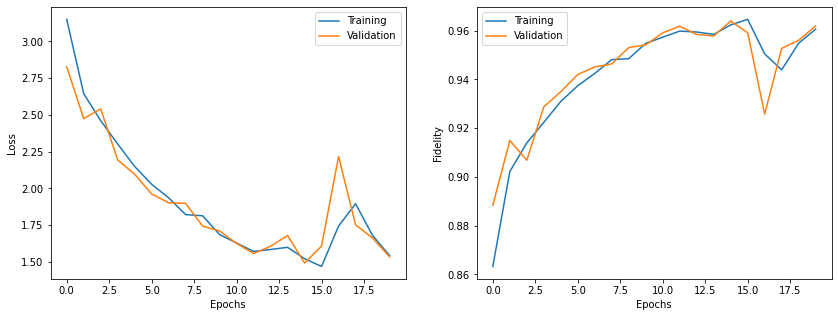

In [ ]:
epochs = range(len(loss_epochs))

fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs,loss_epochs, label='Training')
ax1.plot(epochs,val_loss_epochs, label='Validation')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,fidelity_epochs, label='Training')
ax2.plot(epochs,val_fidelity_epochs, label='Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Fidelity')
ax2.legend()
plt.show()